In [10]:
import io

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as aT
import torchvision.models as models
import torchvision.transforms as vT
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

writer = SummaryWriter()


cuda


## visualize data

Sample Rate: 44100
Shape: (1, 44100)
Dtype: torch.float32
 - Max:     0.634
 - Min:     -0.671
 - Mean:    -4.18e-06
 - Std dev: 0.102
Waveform: tensor([[0.1277, 0.1545, 0.1452,  ..., 0.0046, 0.0048, 0.0024]])


Text(0.5, 1.0, 'Normalized Waveform')

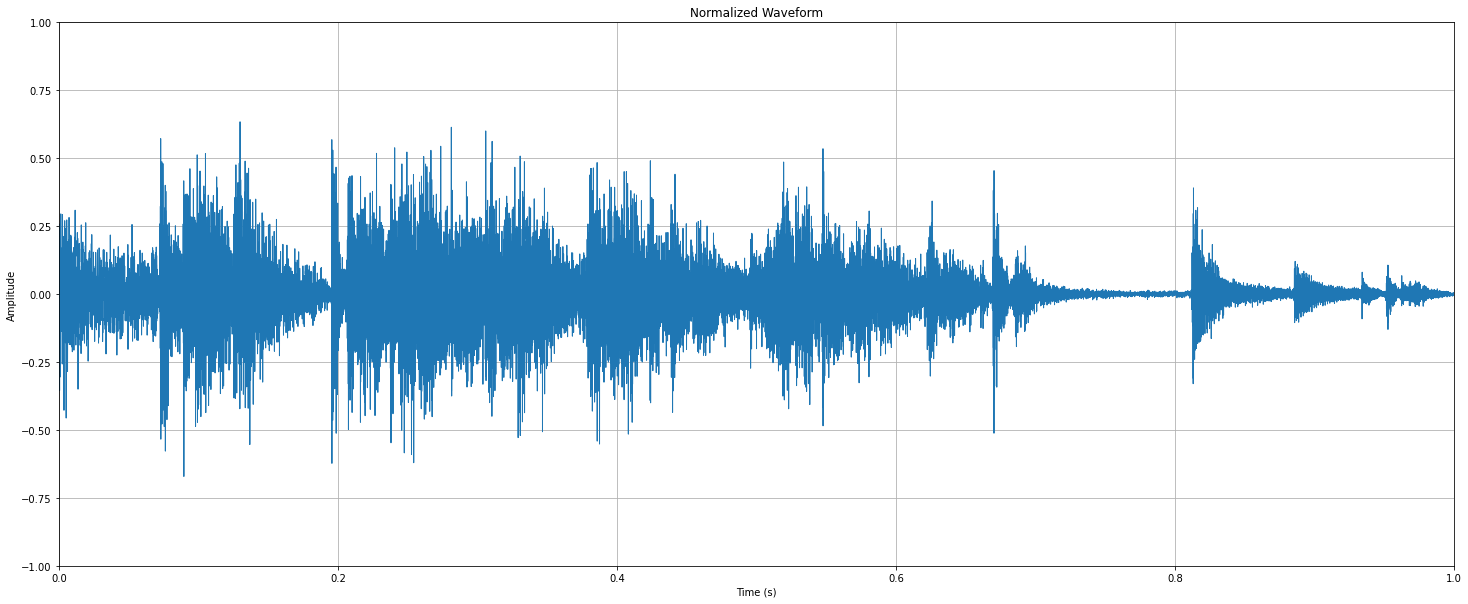

In [ ]:
waveform = torchaudio.load('./dataset/5/147867.wav')
sample_rate = 44100

print("Sample Rate:", sample_rate)
print("Shape:", tuple(waveform.shape))
print("Dtype:", waveform.dtype)
print(f" - Max:     {waveform.max():.3g}")
print(f" - Min:     {waveform.min():.3g}")
print(f" - Mean:    {waveform.mean():.3g}")
print(f" - Std dev: {waveform.std():.3g}")
print("Waveform:", waveform)

figure = plt.figure(figsize=(25, 10))
time_axis = torch.arange(0, len(waveform[0])) / sample_rate
plt.plot(time_axis, waveform[0], linewidth=1)
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.title("Normalized Waveform")


torch.Size([128, 221])


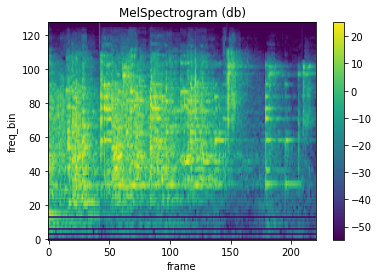

In [ ]:
transforms = nn.Sequential(
    aT.MelSpectrogram(),
    aT.AmplitudeToDB(top_db=80.0),
)

spec = transforms(waveform[0])
print(spec.shape)

plt.imshow(spec, origin='lower', aspect='auto')
plt.title('MelSpectrogram (db)')
plt.ylabel('freq_bin')
plt.xlabel('frame')
plt.colorbar()


In [11]:
def plot_signal(signal, title, cmap=None):
    fig = plt.figure()
    if signal.ndim == 1:
        plt.plot(signal)
    else:
        plt.imshow(signal, cmap=cmap)    
    plt.title(title)
    
    plot_buf = io.BytesIO()
    plt.savefig(plot_buf, format='jpeg')
    plot_buf.seek(0)
    plt.close(fig)

    return vT.ToTensor()(Image.open(plot_buf))

## Load dataset

In [3]:
def audio_loader(path, max_length_in_seconds=4):
    waveform, sample_rate = torchaudio.load(path)
    num_channels, num_frames = waveform.shape
    max_frames = sample_rate * max_length_in_seconds

    # ? Pad audio with zeros if it is too short or
    # ? Cut audio randomly if it is too long
    if num_frames < max_frames:
        waveform = torch.nn.functional.pad(waveform, (0, max_frames - num_frames))
    elif num_frames > max_frames:
        waveform = waveform.narrow(dim=1, start=0, length=max_frames)

    return waveform

transforms = nn.Sequential(
    # aT.MFCC(sample_rate=44100, n_mfcc=64),
    aT.MelSpectrogram(sample_rate=44100, n_mels=32),
    aT.AmplitudeToDB(),
)

dataset = DatasetFolder(root='./dataset', loader=audio_loader, extensions='wav', transform=transforms)
print(f"Input shape: {tuple(dataset[0][0].shape)}")

# unique, counts = np.unique([dataset[i][0].shape for i in range(len(dataset))], return_counts=True)
# print(dict(zip(unique, counts)))


Input shape: (1, 32, 883)


In [4]:
train_dataset, valid_dataset = train_test_split(dataset, test_size=0.1)

# ? dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    pin_memory=True,
    num_workers=2,
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=True,
    pin_memory=False,
    num_workers=2,
)


In [9]:
# from models import AudioRNN, AudioCNN

# audio_cnn = AudioCNN(len(dataset.classes)).to(device)
# print(audio_cnn)

# input_size = 62*41*2

# audio_rnn = AudioRNN(input_size, 5300, 1, len(dataset.classes)).to(device)
# print(audio_rnn)


In [ ]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(
    1,
    model.conv1.out_channels,
    kernel_size=model.conv1.kernel_size[0],
    stride=model.conv1.stride[0],
    padding=model.conv1.padding[0],
)
model.fc = nn.Linear(model.fc.in_features, 10)


In [ ]:
# Hyperparams

lr = 0.001
num_epochs = 20


In [8]:
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs//3, gamma=0.1)
criterion = nn.CrossEntropyLoss()


Sample Rate: 44100
Shape: (1, 44100)
Dtype: torch.float32
 - Max:     0.634
 - Min:     -0.671
 - Mean:    -4.18e-06
 - Std dev: 0.102
Waveform: tensor([[0.1277, 0.1545, 0.1452,  ..., 0.0046, 0.0048, 0.0024]])


Text(0.5, 1.0, 'Normalized Waveform')

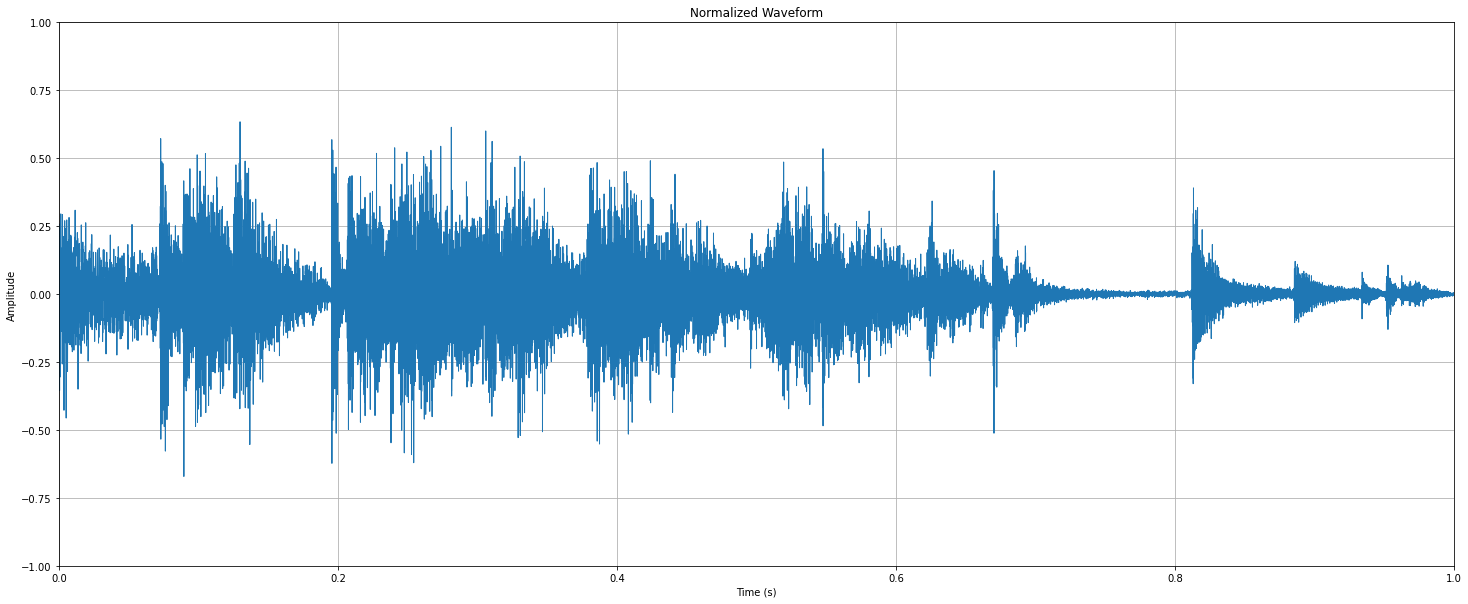

In [ ]:
waveform = audio_loader('./dataset/5/147867.wav')
sample_rate = 44100

print("Sample Rate:", sample_rate)
print("Shape:", tuple(waveform.shape))
print("Dtype:", waveform.dtype)
print(f" - Max:     {waveform.max():.3g}")
print(f" - Min:     {waveform.min():.3g}")
print(f" - Mean:    {waveform.mean():.3g}")
print(f" - Std dev: {waveform.std():.3g}")
print("Waveform:", waveform)

figure = plt.figure(figsize=(25, 10))
time_axis = torch.arange(0, len(waveform[0])) / sample_rate
plt.plot(time_axis, waveform[0], linewidth=1)
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.title("Normalized Waveform")


torch.Size([128, 221])


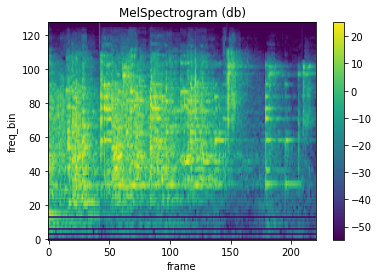

In [ ]:
transforms = nn.Sequential(
    aT.MelSpectrogram(),
    aT.AmplitudeToDB(top_db=80.0),
)

spec = transforms(waveform[0])
print(spec.shape)

plt.imshow(spec, origin='lower', aspect='auto')
plt.title('MelSpectrogram (db)')
plt.ylabel('freq_bin')
plt.xlabel('frame')
plt.colorbar()


In [12]:
def train(model, train_loader, criterion, optimizer, epoch, log_interval=10, debug_interval=25):
    model.train()
    train_loss = 0
    correct = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # ? zero the parameter gradients
        optimizer.zero_grad()

        # ? forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)

        # ? backward pass
        loss.backward()

        # ? optimize
        optimizer.step()

        train_loss += loss.item()
        correct += (predicted == labels).sum().item()

        # ? print training stats
        iteration = epoch * len(train_loader) + batch_idx

        if batch_idx % log_interval == 0:
            writer.add_scalar('training loss/loss', loss, iteration)
            writer.add_scalar('learning rate/lr', optimizer.param_groups[0]['lr'], iteration)
        #     print(
        #         f'Epoch: {epoch}\tLoss: {loss:.6f}'
        #         f'[{batch_idx * len(inputs)}/{len(train_loader.dataset)} '
        #         f'({100. * batch_idx / len(train_loader):.0f}%)]'
        #     )

        # ? report debug image every `debug_interval` mini-batches
        if batch_idx % debug_interval == 0:    
            for n, (inp, pred, label) in enumerate(zip(inputs, predicted, labels)):
                series = f'label_{train_loader.dataset.classes[label.cpu()]}_pred_{train_loader.dataset.classes[pred.cpu()]}'

                writer.add_image(
                    f'Train MelSpectrogram samples/{batch_idx}_{n}_{series}',
                    plot_signal(inp.cpu().numpy().squeeze(), series, 'hot'),
                    iteration
                )

    train_loss /= len(train_loader)
    accuracy = 100 * correct / len(train_loader.dataset)

    return train_loss, accuracy

def valid(model, val_loader, criterion):
    model.eval()
    valid_loss = 0
    num_correct = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)

            valid_loss += loss.item()
            num_correct += (predicted == labels).sum().item()

    valid_loss /= len(val_loader)
    accuracy = 100 * num_correct / len(val_loader.dataset)

    return valid_loss, accuracy


def predict(model, data):
    model.eval()

    with torch.no_grad():
        data = data.unsqueeze(1).to(device)
        output = model(data)
        accuracy, [predicted] = torch.max(output.data, 1)
        accuracy = 100 * accuracy.item()
        predicted = dataset.classes[predicted.item()]

        return predicted, accuracy


In [11]:
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_dataloader, criterion, optimizer, epoch=epoch)
    valid_loss, valid_accuracy = valid(model, valid_dataloader, criterion)
    scheduler.step()

    print(
        f'Epoch: {epoch+1}/{num_epochs}\t'
        f'Training (Loss, Accuracy): ({train_loss:.6f}, {train_accuracy:.2f}%)\t'
        f'Validation (Loss, Accuracy): ({valid_loss:.6f}, {valid_accuracy:.2f}%)\t'
    )

    train_losses.append(train_loss), train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss), valid_accuracies.append(valid_accuracy)


Epoch: 1/100	Training (Loss, Accuracy): (1.971596, 14.74%)	Validation (Loss, Accuracy): (2.003820, 12.50%)	
Epoch: 2/100	Training (Loss, Accuracy): (1.923142, 20.00%)	Validation (Loss, Accuracy): (2.000473, 12.50%)	
Epoch: 3/100	Training (Loss, Accuracy): (1.873910, 25.26%)	Validation (Loss, Accuracy): (1.940991, 20.83%)	
Epoch: 4/100	Training (Loss, Accuracy): (1.803656, 30.53%)	Validation (Loss, Accuracy): (1.987198, 12.50%)	
Epoch: 5/100	Training (Loss, Accuracy): (1.775464, 33.68%)	Validation (Loss, Accuracy): (1.954583, 16.67%)	
Epoch: 6/100	Training (Loss, Accuracy): (1.720339, 37.89%)	Validation (Loss, Accuracy): (1.974791, 16.67%)	
Epoch: 7/100	Training (Loss, Accuracy): (1.703368, 41.05%)	Validation (Loss, Accuracy): (1.952245, 16.67%)	
Epoch: 8/100	Training (Loss, Accuracy): (1.718073, 36.84%)	Validation (Loss, Accuracy): (1.925860, 20.83%)	
Epoch: 9/100	Training (Loss, Accuracy): (1.692773, 40.00%)	Validation (Loss, Accuracy): (1.908320, 20.83%)	
Epoch: 10/100	Training (Loss

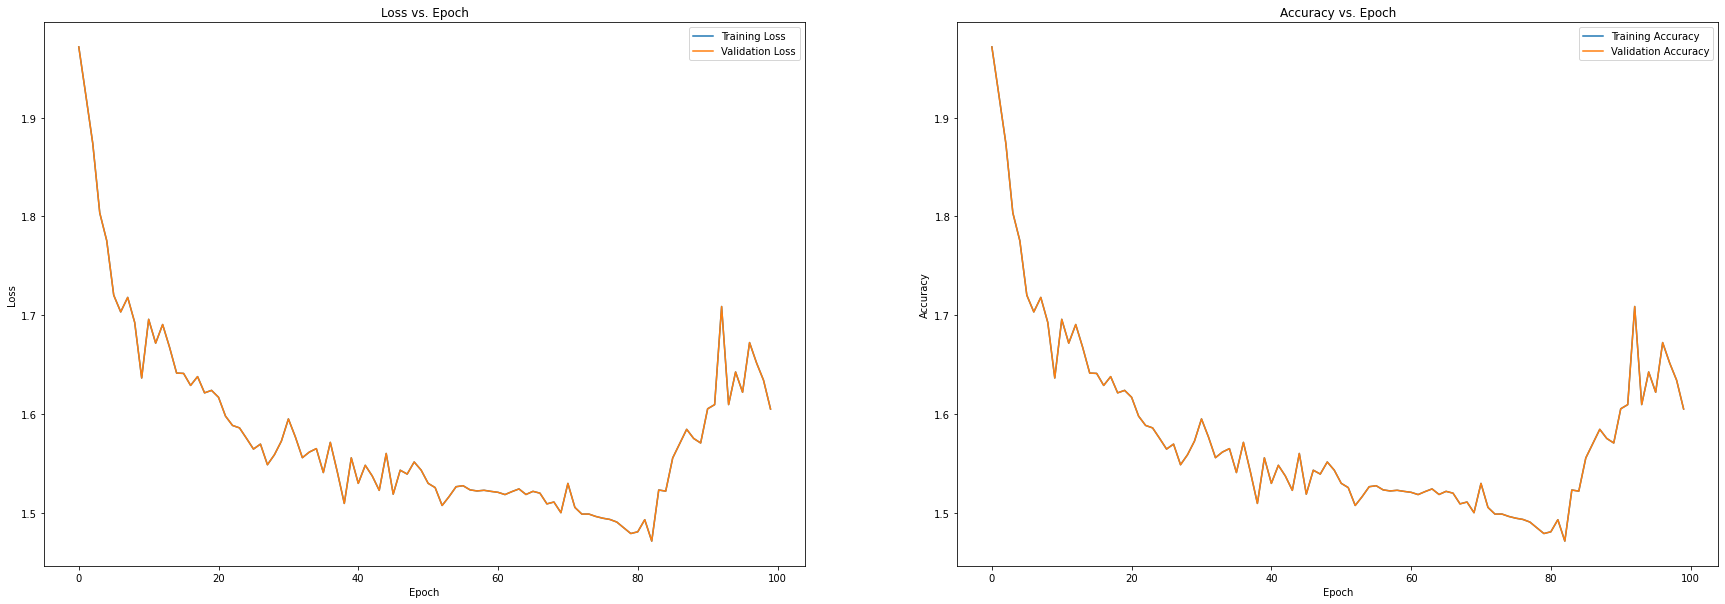

In [28]:
[fig, ax] = plt.subplots(1, 2, figsize=(30, 10))

ax[0].plot(train_losses, label='Training Loss')
ax[0].plot(valid_losses, label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss vs. Epoch')
ax[0].legend()

ax[1].plot(train_accuracies, label='Training Accuracy')
ax[1].plot(valid_accuracies, label='Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy vs. Epoch')
ax[1].legend()


In [54]:
sample = valid_dataloader.dataset[1]
predicted, accuracy = predict(audio_cnn, sample[0])

print(f"Target: {dataset.classes[sample[1]]}, Prediction: {predicted}")


Target: 0, Prediction: 7
